In [2]:
import xarray as xr
import os
import torch
import json
import numpy as np
import matplotlib.pyplot as plt
from cae_tools.models.unet import UNET
from cae_tools.models.model_sizer import ModelSpec

### Load data

In [3]:
process = True # set to true if you have not yet separated train/test
absolute = True
gradient = False
train_percent = 0.85 # train:test split
sample_percent = 0.05 # percent of dataset to sample

if absolute: 
    data_path = r"lustre_scratch/data/absolute"
elif gradient: 
    data_path = r"lustre_scratch/data/gradient"
    

train_path = os.path.join(data_path, "train_test/train_data.nc") # where train data is (to be) stored
test_path = os.path.join(data_path, "train_test/test_data.nc")

file_list = []

for file in os.listdir(data_path):
    if file.endswith('.nc'):
        file_list.append(os.path.join(data_path, file))
N_files = len(file_list)
sample_indices = np.random.randint(N_files, size = int(sample_percent*N_files))
ds_list = []
if process:
    for index in sample_indices: 
        ds_list.append(xr.open_dataset(file_list[index]))
    ds = xr.concat(ds_list, dim = 'i')
    if absolute == True and gradient == False: 
        ds = xr.Dataset({
            "sstL4": ds.sstL4,
            "gRsst": ds.gRsst}) # isolate only sstL4 and gRsst
        ds = ds.expand_dims(dim='channel', axis=1)
        split_index = int(train_percent * len(ds.i))
        train_ds = ds.isel(i=slice(0, split_index))
        test_ds= ds.isel(i=slice(split_index, None))
        train_ds.to_netcdf(train_path)
        test_ds.to_netcdf(test_path)
    elif absolute == False and gradient == True: 
        ds_gr = xr.concat([ds.gRsst_x_grad, ds.gRsst_y_grad], dim = 'channel').transpose("i","channel","y","x")
        ds_l4 = xr.concat([ds.sstL4_x_grad, ds.sstL4_y_grad], dim = 'channel').transpose("i","channel","y","x")
        ds = xr.Dataset({
            "gRsst": ds_gr,
            "sstL4": ds_l4})
        split_index = int(train_percent * len(ds.i))
        train_ds = ds.isel(i=slice(0,split_index))
        test_ds = ds.isel(i=slice(split_index, None))
        train_ds.to_netcdf(train_path)
        test_ds.to_netcdf(test_path)
else: 
    train_ds = xr.open_dataset(train_path)
    test_ds = xr.open_dataset(test_path)

### Define Model

In [6]:
model_path = "models/unet1"

In [5]:
mt = UNET(fc_size=8, encoded_dim_size=16, nr_epochs=500, batch_size = 1000, use_gpu = True) 
layer_definitions_path = r"models/json_files/spec_skip_unet_v1.json"
with open(layer_definitions_path) as f:
    spec = ModelSpec()
    spec.load(json.loads(f.read()))
    mt.spec = spec

### Train and Summarise

In [ ]:
mt.train(["sstL4"], "gRsst", training_ds=train_ds, testing_ds=test_ds, training_paths=train_path, testing_paths=test_path)
print(mt.summary())
mt.save(model_path)

### Load Model

In [7]:
# run this code if you have already trained the model
mt = UNET()
mt.load(model_path)

### Apply Model to Train and Test data

In [8]:
train_scores_path = os.path.join(data_path, "train_test/train_scores.nc")
test_scores_path = os.path.join(data_path, "train_test/test_scores.nc")
mt.apply(train_ds, ["sstL4"], "gRsst_estimate") # add in extra variable of gRsst_estimate
mt.apply(test_ds, ["sstL4"], "gRsst_estimate")
train_ds.to_netcdf(train_scores_path)
test_ds.to_netcdf(test_scores_path)

RuntimeError: Given groups=1, weight of size [8, 2, 2, 2], expected input[1000, 1, 48, 48] to have 2 channels, but got 1 channels instead

In [9]:
train_scores = xr.open_dataset(train_scores_path)
test_scores = xr.open_dataset(test_scores_path)

In [ ]:
test_scores

### Calculate Gradient Magnitude

In [20]:
if gradient == True: 
    sstL4_grad = (test_scores.sstL4.sel(channel = 0)**2 + test_scores.sstL4.sel(channel = 1)**2)**(1/2)
    gRsst_grad = (test_scores.gRsst.sel(channel = 0)**2 + test_scores.gRsst.sel(channel = 1)**2)**(1/2)
    gRsst_estimate_grad =  (test_scores.gRsst_estimate.sel(model_output_channel=0)**2+test_scores.gRsst_estimate.sel(model_output_channel=1)**2)**(1/2)

IndexError: index 1 is out of bounds for axis 0 with size 1

### Generate Random Example Plot

NameError: name 'sstL4_grad' is not defined

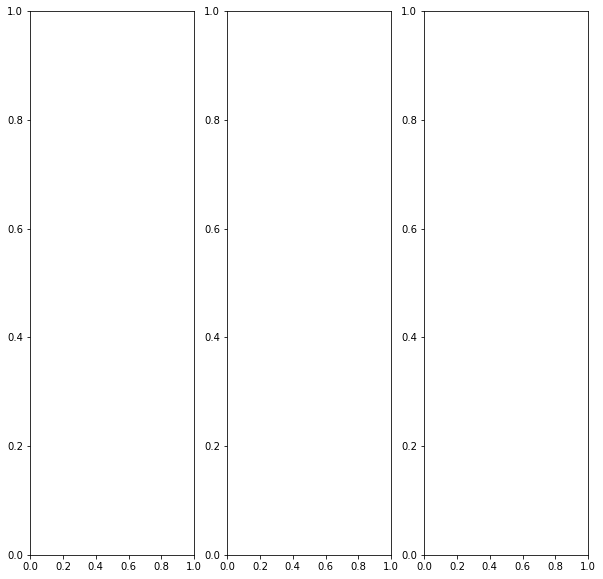

In [19]:
plot_index = np.random.randint(len(test_scores.sstL4)) # random data point to plot
if absolute == True: 
    fig, ax = plt.subplots(1,3, figsize = (10,10))
    ax[0].imshow(test_scores.sstL4[plot_index].data[0])
    ax[0].set_title('sstL4')
    ax[1].imshow(test_scores.gRsst[plot_index].data[0])
    ax[1].set_title('gRsst')
    ax[2].imshow(test_scores.gRsst_estimate[plot_index].data[0])
    ax[2].set_title('gRsst_estimate')
elif gradient == True: 
    fig, ax = plt.subplots(1,3, figsize = (10,10))
    ax[0].imshow(sstL4_grad[plot_index])
    ax[0].set_title('sstL4')
    ax[1].imshow(gRsst_grad[plot_index])
    ax[1].set_title('gRsst')
    ax[2].imshow(gRsst_estimate_grad[plot_index])
    ax[2].set_title('gRsst_estimate')